In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skopt.benchmarks import branin as branin
from skopt.benchmarks import hart6 as hart6_


# redefined `hart6` to allow adding arbitrary "noise" dimensions
def hart6(x):
    return hart6_(x[:6])



<ipython-input-4-7976ab96798b>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cm = ax.pcolormesh(x_ax, y_ax, fx,


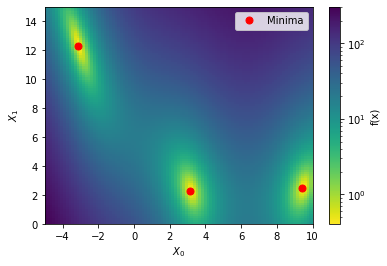

In [4]:
from matplotlib.colors import LogNorm


def plot_branin():
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val) for val in vals], (100, 100))

    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(),
                                    vmax=fx.max()),
                       cmap='viridis_r')

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14,
            lw=0, label="Minima")

    cb = fig.colorbar(cm)
    cb.set_label("f(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("$X_0$")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("$X_1$")
    ax.set_ylim([0, 15])


plot_branin()

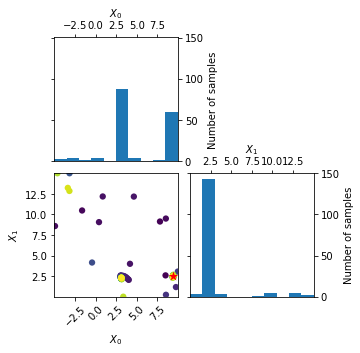

In [5]:
from functools import partial
from skopt.plots import plot_evaluations
from skopt import gp_minimize, forest_minimize, dummy_minimize


bounds = [(-5.0, 10.0), (0.0, 15.0)]
n_calls = 160

gp_res = gp_minimize(branin, bounds, n_calls=n_calls, random_state=4)

_ = plot_evaluations(gp_res, bins=10)


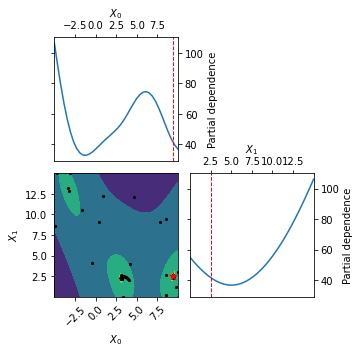

In [11]:
from skopt.plots import plot_objective

_ = plot_objective(gp_res,zscale='log',levels=20)


In [10]:
print(gp_res.keys())

dict_keys(['x', 'fun', 'func_vals', 'x_iters', 'models', 'space', 'random_state', 'specs'])


In [19]:
from skopt.plots import plot_gaussian_process

noise_level = 0.1

def f(x, noise_level=0.0):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

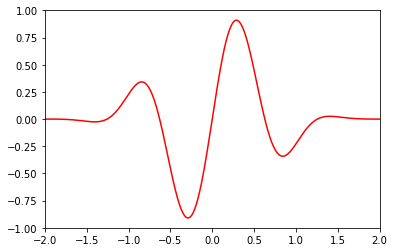

In [16]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r-", label="True (unknown)")
plt.xlim([-2,2])
#plt.fill(np.concatenate([x, x[::-1]]),
#         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
#                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
#         alpha=.2, fc="r", ec="None")
#plt.legend()
#plt.grid()
plt.show()

In [54]:
res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=10,         # the number of evaluations of f
                  n_random_starts=4,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

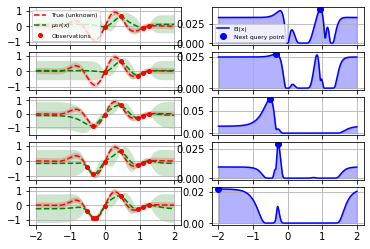

In [55]:
for n_iter in range(5):
    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,
                               objective=f,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()


<AxesSubplot:xlabel='x', ylabel='f(x)'>

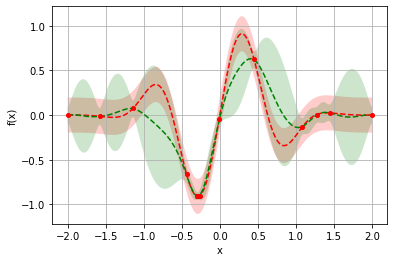

In [45]:
plot_gaussian_process(res, n_calls=10, objective=f, noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=True, show_acq_func=False)

['N=3', 'N=4', 'N=5', 'N=6']


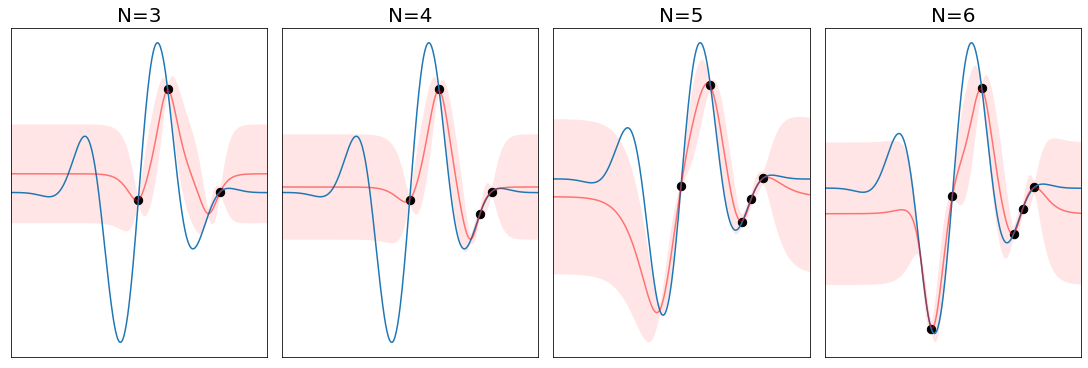

In [96]:
fig = plt.figure(constrained_layout=True,frameon=False,figsize=(15,5))

ax_dict = fig.subplot_mosaic(
    [["N=3","N=4","N=5","N=6"]],
)

keys = ["N=3","N=4","N=5","N=6"]
print(keys)
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]

x_points = np.array(res.x_iters).flatten()
y_points = np.array(res.func_vals)

for i,model in enumerate(res.models[:4]):
    key = keys[i]
    ax_dict[key].plot(x, fx, label="True (unknown)")
    ax_dict[key].set_xlim([-2,2])

    x_model = res.space.dimensions[0].transform(x)
    mu, std = model.predict(x_model,return_std=True) 

    ax_dict[key].set_title(key,fontsize=20)
    ax_dict[key].plot(x, mu, c='r',alpha=0.5)
    ax_dict[key].fill_between(np.linspace(-2, 2, 400), mu+std, mu-std, fc='r', alpha=0.1)
    #ax_dict[key].plot(x, mu-std, c='r',alpha=0.1)

    ax_dict[key].scatter(x_points[:3+i],y_points[:3+i],c='k',s=70)
    ax_dict[key].set_xticks([])
    ax_dict[key].set_yticks([])
    #plt.plot(x, std)

plt.savefig('Bayesian_Optimization.png',bbox_inches='tight')
plt.show()

In [84]:
print(res.models[0].kernel_)
print(res.models[1].kernel_)
print(res.models[2].kernel_)
print(res.models[3].kernel_)

0.998**2 * Matern(length_scale=0.0449, nu=2.5) + WhiteKernel(noise_level=0)
1.02**2 * Matern(length_scale=0.0505, nu=2.5) + WhiteKernel(noise_level=0)
1.17**2 * Matern(length_scale=0.0803, nu=2.5) + WhiteKernel(noise_level=0)
1.05**2 * Matern(length_scale=0.0544, nu=2.5) + WhiteKernel(noise_level=0)
